In [ ]:
# Importing FER(2013) Dataset
! unzip /content/FER_dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [ ]:

import tensorflow as tf
import keras
import cv2
import numpy as np
import itertools
import os
import seaborn as sns
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten,Activation,BatchNormalization

import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50,VGG16, InceptionResNetV2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax

In [ ]:
def plot_images(img_dir, top=10):
    all_img_dirs = os.listdir(img_dir)
    img_files = [os.path.join(img_dir, file) for file in all_img_dirs][:5]
    plt.figure(figsize=(10, 10))
    for idx, img_path in enumerate(img_files):
        plt.subplot(5, 5, idx+1)
        img = plt.imread(img_path)
        plt.tight_layout()
        plt.axis('off')
        plt.imshow(img, cmap='gray')

In [ ]:
train_dir = "/content/train" #passing the path with training images
test_dir = "/content/test"  #passing the path with testing images

Data Augmentation

In [ ]:
train_data_gen = ImageDataGenerator(width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255
                                         )
validation_data_gen = ImageDataGenerator(rescale=1./255)

# Preprocess all test images
train_generator = train_data_gen.flow_from_directory(
        '/content/train',
        target_size=(48, 48),
        batch_size=64,
        class_mode='categorical')

validation_generator = validation_data_gen.flow_from_directory(
        '/content/test',
        target_size=(48, 48),
        batch_size=64,
        class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


\Model With Transfer Learning

In [ ]:
#using pretrained model, RESNET50 architecture
from tensorflow.keras.applications.resnet50 import ResNet50

base_model = ResNet50(input_shape=(48,48,3),include_top = False, weights = 'imagenet')

base_model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 24, 24, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 24, 24, 64)   256         ['conv1_conv[0][0]']             
                          

In [ ]:
emotion_model = Sequential()
emotion_model.add(base_model)
emotion_model.add(Dropout(0.5))
emotion_model.add(Flatten())
emotion_model.add(BatchNormalization())
emotion_model.add(Dense(32,kernel_initializer='he_uniform'))
emotion_model.add(BatchNormalization())
emotion_model.add(Activation('relu'))
emotion_model.add(Dropout(0.5))
emotion_model.add(Dense(32,kernel_initializer='he_uniform'))
emotion_model.add(BatchNormalization())
emotion_model.add(Activation('relu'))
emotion_model.add(Dropout(0.5))
emotion_model.add(Dense(32,kernel_initializer='he_uniform'))
emotion_model.add(BatchNormalization())
emotion_model.add(Activation('relu'))
emotion_model.add(Dense(7,activation='softmax'))


emotion_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001, decay=1e-6), metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
emotion_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 2, 2, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 batch_normalization (BatchN  (None, 8192)             32768     
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                262176    
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                        

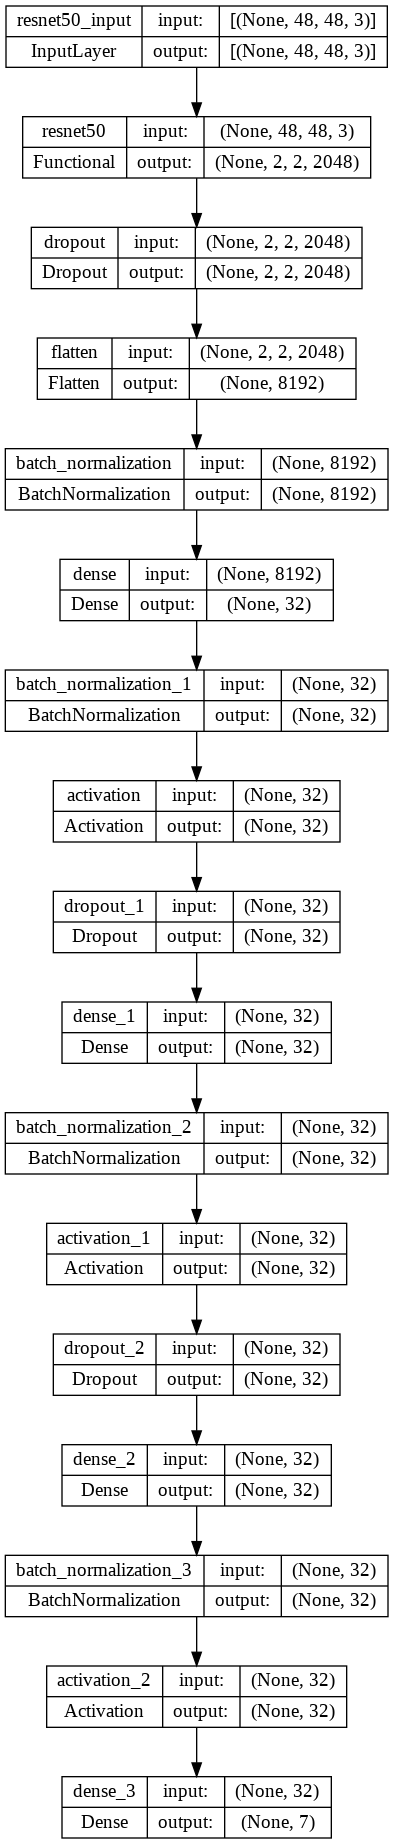

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(emotion_model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')

In [ ]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)
mc = ModelCheckpoint('model_resnet.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [ ]:
history = emotion_model.fit_generator(train_generator,steps_per_epoch=28709 // 64,epochs = 6,validation_data = validation_generator,callbacks=[lrd,mc],verbose = 1,validation_steps=7178 // 64)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/6
448/448 [==============================] - ETA: 0s - loss: 2.0685 - accuracy: 0.1656
Epoch 1: val_accuracy improved from -inf to 0.17188, saving model to model_resnet.h5
448/448 [==============================] - 4528s 10s/step - loss: 2.0685 - accuracy: 0.1656 - val_loss: 8.8937 - val_accuracy: 0.1719 - lr: 1.0000e-04
Epoch 2/6
448/448 [==============================] - ETA: 0s - loss: 1.9237 - accuracy: 0.2120
Epoch 2: val_accuracy improved from 0.17188 to 0.30176, saving model to model_resnet.h5
448/448 [==============================] - 4492s 10s/step - loss: 1.9237 - accuracy: 0.2120 - val_loss: 1.8070 - val_accuracy: 0.3018 - lr: 1.0000e-04
Epoch 3/6
448/448 [==============================] - ETA: 0s - loss: 1.8312 - accuracy: 0.2769
Epoch 3: val_accuracy improved from 0.30176 to 0.34222, saving model to model_resnet.h5
448/448 [==============================] - 4377s 10s/step - loss: 1.8312 - accuracy: 0.2769 - val_loss: 1.6951 - val_accuracy: 0.3422 - lr: 1.0000e-04
E

Plotting Confusion Matrix

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap='viridis'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.style.use('seaborn-darkgrid')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
classes= ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [ ]:
test_path="/content/test"
validation_datagen1= ImageDataGenerator(rescale = 1./255)
test1_generator = validation_datagen1.flow_from_directory(directory=test_path, batch_size=64, classes=classes,class_mode="categorical", target_size=(64,64), shuffle=False)
y_true = test1_generator.classes
y_hat =  emotion_model.predict(test1_generator)
y_hat = tf.argmax(y_hat, axis = 1).numpy()

Found 7178 images belonging to 7 classes.
113/113 [==============================] - 102s 890ms/step


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score
accuracy = accuracy_score(y_true, y_hat,)
print('Accuracy: %f' % accuracy)
precision = precision_score(y_true, y_hat,average='micro')
f1 = f1_score(y_true, y_hat,average='micro')
print('F1 score: %f' % f1)

Accuracy: 0.305238
F1 score: 0.305238


Confusion matrix, without normalization
[[   4    0    0  712   41  200    1]
 [   0    0    0   88    1   22    0]
 [  15    0    5  758   40  202    4]
 [   4    0    0 1700   14   53    3]
 [   4    0    1  885  105  237    1]
 [  16    0    0  836   64  331    0]
 [  21    0    8  633   42   81   46]]


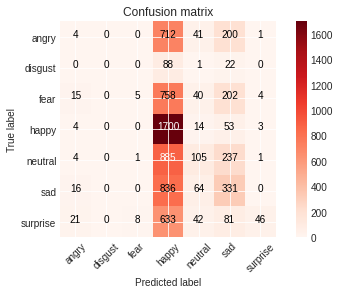

In [ ]:
cm = confusion_matrix(y_true = y_true, y_pred = y_hat)
plot_confusion_matrix(cm, classes, cmap = 'Reds')
plt.savefig('confmat.png')